In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from kernels import *
import pdb
import gpytorch
from itertools import product

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x = torch.linspace(float(0), float(1), int(50))
one = torch.sin(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.2)
two = torch.cos(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.2)
train_y = torch.stack([one, two], int(-1))


In [3]:
train_x.shape

torch.Size([50])

In [4]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        kernel = Diff_SE_kernel()
        kernel2 = Diff_SE_kernel()
        q, dx1, dx2 = var('q, dx1, dx2')
        L = matrix(2, 2, (1, dx1, 0, 1))
        R = matrix(2, 2, (1, 0, dx2, 2))
        p = DiffMatrixKernel([[kernel, None], [None, kernel]])
        self.covar_module = p.diff(left_matrix=L, right_matrix=R)
        #kernel0 = Diff_SE_kernel()
        #kernel1 = Diff_SE_kernel()
        #kernel2 = Diff_SE_kernel()
        #self.covar_module = MatrixKernel([[kernel0, None], [None, kernel2]])

    def forward(self, x):
        #pdb.set_trace()
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        #print(f"{covar_x.detach().evaluate()}")
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x, validate_args=True)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

List of all kernels: [Diff_SE_kernel()]
[[AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
), AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
)], [AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
), AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
)]]


In [5]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = int(2) if smoke_test else int(20)


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=float(0.1))  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    for parameter in model.named_parameters():
        print(parameter)
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  variance: %.3f noise: %.3f' % (
    #    i + 1, training_iter, loss.item(),
    #    model.covar_module.length.item(),
    #    model.covar_module.var.item(),
    #    model.likelihood.noise.item()
    #))
    optimizer.step()

('likelihood.raw_task_noises', Parameter containing:
tensor([0., 0.], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([0.], requires_grad=True))
('covar_module.11922674928.var', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.11922674928.length', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.11922675216.var', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.11922675216.length', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.11922675168.var', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.11922675168.length', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.11922675648.var', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.11922675648.length', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.11922771008.var', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.11922771008.length

('likelihood.raw_task_noises', Parameter containing:
tensor([-0.2001, -0.1974], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([-0.1998], requires_grad=True))
('covar_module.11922674928.var', Parameter containing:
tensor(1.1539, requires_grad=True))
('covar_module.11922674928.length', Parameter containing:
tensor(0.8270, requires_grad=True))
('covar_module.11922675216.var', Parameter containing:
tensor(1.1683, requires_grad=True))
('covar_module.11922675216.length', Parameter containing:
tensor(0.8267, requires_grad=True))
('covar_module.11922675168.var', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.11922675168.length', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.11922675648.var', Parameter containing:
tensor(0.8301, requires_grad=True))
('covar_module.11922675648.length', Parameter containing:
tensor(1.1724, requires_grad=True))
('covar_module.11922771008.var', Parameter containing:
tensor(1., requires_grad=T

('likelihood.raw_task_noises', Parameter containing:
tensor([-0.5012, -0.4955], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([-0.5013], requires_grad=True))
('covar_module.11922674928.var', Parameter containing:
tensor(1.1959, requires_grad=True))
('covar_module.11922674928.length', Parameter containing:
tensor(0.6783, requires_grad=True))
('covar_module.11922675216.var', Parameter containing:
tensor(1.2836, requires_grad=True))
('covar_module.11922675216.length', Parameter containing:
tensor(0.6776, requires_grad=True))
('covar_module.11922675168.var', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.11922675168.length', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.11922675648.var', Parameter containing:
tensor(0.6957, requires_grad=True))
('covar_module.11922675648.length', Parameter containing:
tensor(1.3154, requires_grad=True))
('covar_module.11922771008.var', Parameter containing:
tensor(1., requires_grad=T

('likelihood.raw_task_noises', Parameter containing:
tensor([-0.8042, -0.7998], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([-0.8062], requires_grad=True))
('covar_module.11922674928.var', Parameter containing:
tensor(1.1599, requires_grad=True))
('covar_module.11922674928.length', Parameter containing:
tensor(0.5745, requires_grad=True))
('covar_module.11922675216.var', Parameter containing:
tensor(1.3331, requires_grad=True))
('covar_module.11922675216.length', Parameter containing:
tensor(0.5566, requires_grad=True))
('covar_module.11922675168.var', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.11922675168.length', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.11922675648.var', Parameter containing:
tensor(0.6118, requires_grad=True))
('covar_module.11922675648.length', Parameter containing:
tensor(1.4049, requires_grad=True))
('covar_module.11922771008.var', Parameter containing:
tensor(1., requires_grad=T

('likelihood.raw_task_noises', Parameter containing:
tensor([-1.1098, -1.1079], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([-1.1138], requires_grad=True))
('covar_module.11922674928.var', Parameter containing:
tensor(1.0863, requires_grad=True))
('covar_module.11922674928.length', Parameter containing:
tensor(0.4971, requires_grad=True))
('covar_module.11922675216.var', Parameter containing:
tensor(1.3336, requires_grad=True))
('covar_module.11922675216.length', Parameter containing:
tensor(0.4930, requires_grad=True))
('covar_module.11922675168.var', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.11922675168.length', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.11922675648.var', Parameter containing:
tensor(0.5535, requires_grad=True))
('covar_module.11922675648.length', Parameter containing:
tensor(1.4671, requires_grad=True))
('covar_module.11922771008.var', Parameter containing:
tensor(1., requires_grad=T

('likelihood.raw_task_noises', Parameter containing:
tensor([-1.4172, -1.4182], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([-1.4231], requires_grad=True))
('covar_module.11922674928.var', Parameter containing:
tensor(0.9857, requires_grad=True))
('covar_module.11922674928.length', Parameter containing:
tensor(0.4428, requires_grad=True))
('covar_module.11922675216.var', Parameter containing:
tensor(1.2844, requires_grad=True))
('covar_module.11922675216.length', Parameter containing:
tensor(0.5414, requires_grad=True))
('covar_module.11922675168.var', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.11922675168.length', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.11922675648.var', Parameter containing:
tensor(0.5116, requires_grad=True))
('covar_module.11922675648.length', Parameter containing:
tensor(1.5122, requires_grad=True))
('covar_module.11922771008.var', Parameter containing:
tensor(1., requires_grad=T

('likelihood.raw_task_noises', Parameter containing:
tensor([-1.7251, -1.7297], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([-1.7333], requires_grad=True))
('covar_module.11922674928.var', Parameter containing:
tensor(0.8674, requires_grad=True))
('covar_module.11922674928.length', Parameter containing:
tensor(0.3797, requires_grad=True))
('covar_module.11922675216.var', Parameter containing:
tensor(1.2132, requires_grad=True))
('covar_module.11922675216.length', Parameter containing:
tensor(0.5974, requires_grad=True))
('covar_module.11922675168.var', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.11922675168.length', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.11922675648.var', Parameter containing:
tensor(0.4800, requires_grad=True))
('covar_module.11922675648.length', Parameter containing:
tensor(1.5455, requires_grad=True))
('covar_module.11922771008.var', Parameter containing:
tensor(1., requires_grad=T

In [6]:
for parameter in model.named_parameters():
    print(parameter)

('likelihood.raw_task_noises', Parameter containing:
tensor([-2.0319, -2.0401], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([-2.0420], requires_grad=True))
('covar_module.11922674928.var', Parameter containing:
tensor(0.7542, requires_grad=True))
('covar_module.11922674928.length', Parameter containing:
tensor(0.2769, requires_grad=True))
('covar_module.11922675216.var', Parameter containing:
tensor(1.1348, requires_grad=True))
('covar_module.11922675216.length', Parameter containing:
tensor(0.6118, requires_grad=True))
('covar_module.11922675168.var', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.11922675168.length', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.11922675648.var', Parameter containing:
tensor(0.4551, requires_grad=True))
('covar_module.11922675648.length', Parameter containing:
tensor(1.5705, requires_grad=True))
('covar_module.11922771008.var', Parameter containing:
tensor(1., requires_grad=T

In [7]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots

number_of_samples = int(50)
# Make predictions
with torch.no_grad():#, gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(float(0), float(2), number_of_samples)
    #pdb.set_trace()
    outputs = model(test_x)
    predictions = likelihood(outputs)
    
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
#print(mean)
#print(lower)
#print(upper)
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

#dims = int(2)
#indices = [list(range(i, len(train_y), dims)) for i in range(dims)]


Result:
tensor([[3.7859, 3.7788, 3.7575,  ..., 0.2937, 0.2976, 0.3013],
        [3.7788, 3.7859, 3.7788,  ..., 0.2897, 0.2937, 0.2976],
        [3.7575, 3.7788, 3.7859,  ..., 0.2856, 0.2897, 0.2937],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 2.5975, 2.5943, 2.5847],
        [0.0000, 0.0000, 0.0000,  ..., 2.5943, 2.5975, 2.5943],
        [0.0000, 0.0000, 0.0000,  ..., 2.5847, 2.5943, 2.5975]])
Symmetric result:
tensor([[3.7859, 3.7788, 3.7575,  ..., 0.2937, 0.2976, 0.3013],
        [3.7788, 3.7859, 3.7788,  ..., 0.2897, 0.2937, 0.2976],
        [3.7575, 3.7788, 3.7859,  ..., 0.2856, 0.2897, 0.2937],
        ...,
        [0.2937, 0.2897, 0.2856,  ..., 2.5975, 2.5943, 2.5847],
        [0.2976, 0.2937, 0.2897,  ..., 2.5943, 2.5975, 2.5943],
        [0.3013, 0.2976, 0.2937,  ..., 2.5847, 2.5943, 2.5975]])
Interleaved result:
tensor([[ 3.7859,  0.0000,  3.7788,  ...,  0.2976, -1.3314,  0.3013],
        [ 0.0000,  2.5975, -0.0075,  ...,  0.1504, -0.3013,  0.1334],
        [ 3.7788, 

Text(0.5, 1.0, 'Observed Values (Likelihood)')

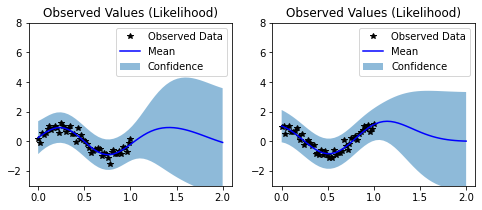

In [8]:
f, (y1_ax, y2_ax) = plt.subplots(int(1), int(2), figsize=(int(8), int(3)))

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 8])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 8])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')


# Test Diffable SE Kernel

In [9]:
X = torch.tensor([int(1), int(2), int(3)])
X

tensor([1, 2, 3])

In [10]:
x1, x2, l, sigma = var('x1, x2, l, sigma')
lengthscale = 1
variance = 1
SE(x1, x2, l, sigma) = sigma^2*exp(-(x1-x2)^2/(2*l^2))
cov_matr = [[None for i in range(len(X))] for j in range(len(X))]
for i, (v1, v2) in enumerate(product(X, X)):
    cov_matr[int(i/len(X))][int(i%len(X))] = float(SE.diff(x2).diff(x1)(int(v1), int(v2), lengthscale, variance))
cov_matr

[[1.0, 0.0, -0.4060058497098381],
 [0.0, 1.0, 0.0],
 [-0.4060058497098381, 0.0, 1.0]]

In [11]:
SE.operands()

[sigma^2, e^(-1/2*(x1 - x2)^2/l^2)]

In [12]:
a = Diff_SE_kernel(var=int(variance), length=int(lengthscale))
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx2
right_poly = dx1 
diffed_kernel = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
left_poly = dx2
right_poly = 1
diffed_kernel2 = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
diffed_kernel(X).evaluate() + diffed_kernel2(X).evaluate()

tensor([[ 1.0000,  0.6065, -0.1353],
        [-0.6065,  1.0000,  0.6065],
        [-0.6767, -0.6065,  1.0000]], grad_fn=<AddBackward0>)

In [13]:
def calc_cell_diff(L, M, R, context=None):
    len_M = np.shape(M)[0]
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
       map(list, itertools.zip_longest(*M, fillvalue=None)))
    for r_elem, row_M in zip(R, M_transpose):
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                if m_elem is not None:
                    temp = l_elem * m_elem*r_elem
                    #temp = l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
            else:
                if m_elem is not None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                    temp += l_elem * m_elem*r_elem
                    #temp += l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
    return temp.simplify_full()


In [14]:
dimension = 3
length = dimension*dimension +1
L_list = [var(f'l_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
M_list = [var(f'm_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
R_list = [var(f'r_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
L = matrix(dimension, dimension, L_list)
M = matrix(dimension, dimension, M_list)
R = matrix(dimension, dimension, R_list)
print(L)
print(M)
print(R)
row = 0
col = 0
for row in range(dimension):
    for col in range(dimension):
        print((L*M*R)[row][col])
print("\n\n")
for i, (l, r) in enumerate(itertools.product(L.rows(), R.columns())):

    print(calc_cell_diff(l, M, r))
    print("\n")

[l_11 l_12 l_13]
[l_21 l_22 l_23]
[l_31 l_32 l_33]
[m_11 m_12 m_13]
[m_21 m_22 m_23]
[m_31 m_32 m_33]
[r_11 r_12 r_13]
[r_21 r_22 r_23]
[r_31 r_32 r_33]
(l_11*m_11 + l_12*m_21 + l_13*m_31)*r_11 + (l_11*m_12 + l_12*m_22 + l_13*m_32)*r_21 + (l_11*m_13 + l_12*m_23 + l_13*m_33)*r_31
(l_11*m_11 + l_12*m_21 + l_13*m_31)*r_12 + (l_11*m_12 + l_12*m_22 + l_13*m_32)*r_22 + (l_11*m_13 + l_12*m_23 + l_13*m_33)*r_32
(l_11*m_11 + l_12*m_21 + l_13*m_31)*r_13 + (l_11*m_12 + l_12*m_22 + l_13*m_32)*r_23 + (l_11*m_13 + l_12*m_23 + l_13*m_33)*r_33
(l_21*m_11 + l_22*m_21 + l_23*m_31)*r_11 + (l_21*m_12 + l_22*m_22 + l_23*m_32)*r_21 + (l_21*m_13 + l_22*m_23 + l_23*m_33)*r_31
(l_21*m_11 + l_22*m_21 + l_23*m_31)*r_12 + (l_21*m_12 + l_22*m_22 + l_23*m_32)*r_22 + (l_21*m_13 + l_22*m_23 + l_23*m_33)*r_32
(l_21*m_11 + l_22*m_21 + l_23*m_31)*r_13 + (l_21*m_12 + l_22*m_22 + l_23*m_32)*r_23 + (l_21*m_13 + l_22*m_23 + l_23*m_33)*r_33
(l_31*m_11 + l_32*m_21 + l_33*m_31)*r_11 + (l_31*m_12 + l_32*m_22 + l_33*m_32)*r_21 +

In [15]:
def calc_cell_diff_sage(L, M, R, context=None):
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
        map(list, itertools.zip_longest(*M, fillvalue=None)))
    # Every row in 'M' is combined with each elem of the row given in 'R'
    # Or: For each elemtn in row 'R' combine with 'row_M'
    for r_elem, row_M in zip(R, M_transpose):
        # Each element in L gets exactly one element in 'row_M' to multiply
        # Or: Combine each element in row_M with exactly one element in 'L'
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp = m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp = m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp = m_elem.diff(l_elem)
                else:
                    pass
            else:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp += m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp += m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp += m_elem.diff(l_elem)
                    
                else:
                    pass
    return temp

def diff_sage(matrix, left_matrix=None, right_matrix=None):
    # iterate left matrix by rows and right matrix by columns and call the
    # respective diff command of the kernels with the row/cols as params
    kernel = MatrixKernel(None)
    output_matrix = [[0 for i in range(np.shape(matrix)[1])] for j in range(np.shape(matrix)[0])]
    for i, (l, r) in enumerate(itertools.product(left_matrix.rows(), right_matrix.columns())):
        res = calc_cell_diff_sage(l, matrix, r, context=kernel)
        output_matrix[int(i/np.shape(matrix)[0])][
                    int(i % np.shape(matrix)[0])]  = res
    kernel.set_matrix(output_matrix)
    return output_matrix


In [16]:
L = matrix(2, 2, (x1, x1, 0, x1))
R = matrix(2, 2, (x2, 0, x2, x2))
x1, x2, l, sigma = var('x1, x2, l, sigma')
lengthscale = 1
variance = 1
SEKernelMatrix = [[sigma^2*exp(-(x1-x2)^2/(2*l^2)), None], [None, sigma^2*exp(-(x1-x2)^2/(2*l^2))]]
diffed_SE_sage_matrix_kernel = diff_sage(SEKernelMatrix, left_matrix=L, right_matrix=R)
pprint.pprint(diffed_SE_sage_matrix_kernel)
cov_matr = [[None for i in range(len(X)*len(diffed_SE_sage_matrix_kernel))] for j in range(len(X)*len(diffed_SE_sage_matrix_kernel))]
for i, (v1, v2) in enumerate(product(X, X)):
    for row in range(len(diffed_SE_sage_matrix_kernel)):
        for col in range(len(diffed_SE_sage_matrix_kernel)):
            # Blockwise
            cov_matr[int(i/len(X))+row*len(X)][int(i%len(X))+col*len(X)] = diffed_SE_sage_matrix_kernel[row][col].substitute(x1=int(v1), x2=int(v2), l=lengthscale, sigma=variance)
            # Interleaved
            #cov_matr[int(((i*len(diffed_SE_sage_matrix_kernel))+row)/(len(X)*len(diffed_SE_sage_matrix_kernel)))*2+row][int((i*len(diffed_SE_sage_matrix_kernel))+col)%(len(X)*len(diffed_SE_sage_matrix_kernel))] = float(diffed_SE_sage_matrix_kernel[row][col].substitute(x1=int(v1), x2=int(v2), l=lengthscale, sigma=variance))
cov_matr


NameError: name 'pprint' is not defined

In [ ]:

kernel = Diff_SE_kernel()
kernel2 = Diff_SE_kernel()
q, dx1, dx2 = var('q, dx1, dx2')
L = matrix(2, 2, (dx1, dx1, 0, dx1))
R = matrix(2, 2, (dx2, 0, dx2, dx2))

p = DiffMatrixKernel([[kernel, None], [None, kernel2]])
covar_module = p.diff(left_matrix=L, right_matrix=R)

covar_x = covar_module(X)
covar_x.evaluate()

In [ ]:
matr = [[2, 0, -6*e^(-2), 1, e^(-1/2), -e^(-2)],
 [0, 2, 0, -e^(-1/2), 1, e^(-1/2)],
 [-6*e^(-2), 0, 2, -5*e^(-2), -e^(-1/2), 1],
 [1, e^(-1/2), -e^(-2), 1, 0, -3*e^(-2)],
 [-e^(-1/2), 1, e^(-1/2), 0, 1, 0],
 [-5*e^(-2), -e^(-1/2), 1, -3*e^(-2), 0, 1]]

matr = [[2, 0, -6*e^(-2), 1, 0, -3*e^(-2)],
 [0, 2, 0, 0, 1, 0],
 [-6*e^(-2), 0, 2, -3*e^(-2), 0, 1],
 [1, 0, -3*e^(-2), 1, 0, -3*e^(-2)],
 [0, 1, 0, 0, 1, 0],
 [-3*e^(-2), 0, 1, -3*e^(-2), 0, 1]]

matr = torch.Tensor(matr)
import pprint
pprint.pprint(matr)
print(matr[0::3, 0::3])
H_x = 3
torch.vstack([torch.hstack([matr[k::H_x, l::H_x] for l in range(H_x)]) for k in range(H_x)])

In [ ]:
class testobject():
    def __init__(self, val):
        self.val = val
    
    def setVal(self, val):
        self.val = val
        
    def printVal(self):
        return self.val
    
    def __call__(self):
        return self.val

In [ ]:
t1 = testobject(42)
t2 = testobject(21)
t3 = testobject(17)
l = [[t1, t2], [t2, t3]]
print(l)
t2.setVal(170)
print(l[0][1].printVal())
print(l[1][0].printVal())

In [ ]:
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx1
right_poly = dx2
L = matrix(2, 2, (dx1, 0, 0, dx1))
R = matrix(2, 2, (dx2, 0, 0, dx2))

In [ ]:
p.diff(left_matrix=L, right_matrix=R).forward(X, X)

In [ ]:
w, q, dx1, dx2 = var('w, q, dx1, dx2')
a = dx1^2
#a.degree(dx1)
a.operands()

In [ ]:
prod([1,2,3])

In [ ]:
a = torch.Tensor([[int(1), int(2), int(3)], [int(4), int(5), int(6)], [int(7), int(8), int(9)]])
for i, row in enumerate(a):
    for j, elem in enumerate(row[i:]):
        print(f"row: {i}, col: {i+j}")
        print(elem)

In [ ]:
a, b, c, d = var('a, b, c, d')
A = matrix(2,2, (a, b, c, d))
B = matrix(2, 2, (dx1, dx1, 0, dx1))
C = matrix(2, 2, (dx2, 0, dx2, dx2))
print(A)
print(B)
B*A

In [ ]:
x = ['a', 'b', 'c']
y = x                 # x and y reference the same object
z = ['a', 'b', 'c']   # x and z reference different objects
#z


